/var/folders/3n/6w3dcl_j6hsdtz5gbk6q7rbm0000gn/T/ipykernel_2027/1583901551.py:44: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif resample or is_categorical_dtype(x_type) or np.issubdtype(x_type, np.integer):


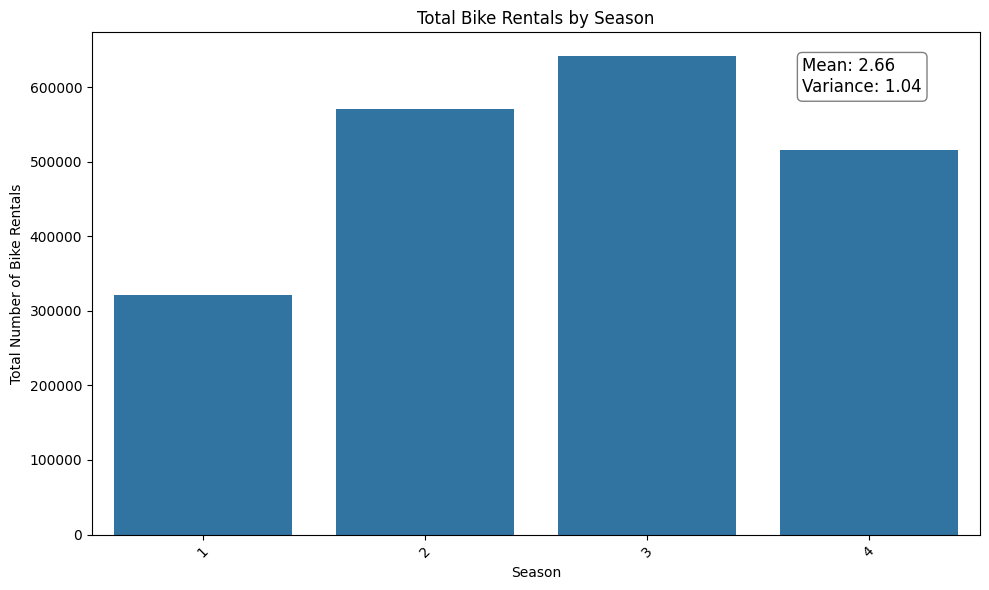

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype, is_categorical_dtype

class HurryPlotter:
    def __init__(self, dataframe):
        # Store the DataFrame directly
        self.data = dataframe

        # Ensure all datetime columns are converted to datetime objects
        for col in self.data.columns:
            if self.data[col].dtype == 'object':
                try:
                    self.data[col] = pd.to_datetime(self.data[col])
                except ValueError:
                    pass

    def plot(self, x, y, title='Title', x_label='x-axis', y_label='y-axis', groupby=None, filter_condition=None, resample=None, show_statistics=False):
        # Make a copy of the DataFrame to avoid modifying the original data
        data_to_plot = self.data.copy()
    
        # Filter data if a condition is provided
        if filter_condition:
            data_to_plot = data_to_plot.query(filter_condition)
        
        # If resample is specified, perform resampling and sum the data
        if resample and is_datetime64_any_dtype(data_to_plot[x]):
            data_to_plot = data_to_plot.resample(resample, on=x)[y].sum().reset_index()
            data_to_plot[x] = data_to_plot[x].dt.strftime('%Y-%m')  # Format the datetime column
        
        # Group data if groupby is specified and perform sum
        elif groupby:
            data_to_plot = data_to_plot.groupby(groupby)[y].sum().reset_index()

        # Determine the type of the x-axis
        x_type = data_to_plot[x].dtype

        if is_datetime64_any_dtype(x_type) or np.issubdtype(x_type, np.float64): #is_numeric_dtype(x_type)
            plot_func = sns.lineplot
            is_date = is_datetime64_any_dtype(x_type)
        elif resample or is_categorical_dtype(x_type) or np.issubdtype(x_type, np.integer):
            plot_func = sns.barplot
            is_date = False
        else:
            raise ValueError("x-axis type not supported for plotting")

        plt.figure(figsize=(10, 6))
        plot_func(data=data_to_plot, x=x, y=y)
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        if is_date:
            # Set the locator and formatter for x-axis to show dates nicely
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            ax.set_xlim(data_to_plot[x].min(), data_to_plot[x].max())

        if (groupby or resample) and show_statistics:
            weighted_stats = self.calculate_weighted_stats(data_to_plot, groupby, y)
            self.display_stats(plt.gca(), weighted_stats)

        plt.xticks(rotation=45)
        plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
        plt.show()

    @staticmethod
    def calculate_weighted_stats(data, groupby_col, value_col):
        weighted_mean_value = np.average(data[groupby_col], weights=data[value_col])
        weighted_variance_value = np.average((data[groupby_col] - weighted_mean_value) ** 2, weights=data[value_col])
        return {'mean': weighted_mean_value, 'variance': weighted_variance_value}

    @staticmethod
    def display_stats(ax, stats):
        textstr = f'Mean: {stats["mean"]:.2f}\nVariance: {stats["variance"]:.2f}'
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.8, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)


def inverse_min_max_scaling(scaled_val, original_min, original_max):
    return scaled_val * (original_max - original_min) + original_min

if __name__ == '__main__':

    # Loading data and preprocessing
    df = pd.read_csv("./data/hour.csv")
    df.drop_duplicates()

    # Convert time to datetime format for better visulization
    df['dteday'] = pd.to_datetime(df['dteday'])
    df['dtehr'] = df.apply(lambda row: row['dteday'] + pd.Timedelta(hours=row['hr']), axis=1)

    # Restore min max scaled variable to the original for better visulization
    df['temp_origin'] = df['temp'].apply(lambda x: inverse_min_max_scaling(x, -8, 39))
    df['atemp_origin'] = df['atemp'].apply(lambda x: inverse_min_max_scaling(x, -16, 50))
    df['windspeed_origin'] = df['windspeed'].apply(lambda x: x*67)

    # Initialization of HurryPlotter
    plotter = HurryPlotter(df)
    #plotter.plot(x='dteday', y='cnt', title='Time Series Plot of Bike Rentals', x_label='Time', y_label='Number of Bike Rentals',resample='Q')
    #plotter.plot(x='season', y='cnt', groupby='season', title='Total Bike Rentals by Season', x_label='Season', y_label='Total Number of Bike Rentals', show_statistics=True)
    #plotter.plot(x='temp', y='cnt', groupby='temp', title='Temperature Rental', x_label='Temperature', y_label='Total Number of Bike Rentals')
    plotter.plot(x='season', y='cnt', groupby='season', filter_condition='yr==1', title='Total Bike Rentals by Season', x_label='Season', y_label='Total Number of Bike Rentals', show_statistics=True)




Doing NN training.
Epoch 1000, Loss: 57.1507219966756
Epoch 2000, Loss: 51.29134611623955
The MAE error on train dataset: 51.58, and on test dataset: 57.93


Doing DBSCAN outliers detection.
Estimated number of clusters: 95
Estimated number of noise points: 473

Doing NN training.
Epoch 1000, Loss: 56.489419183167435
Epoch 2000, Loss: 54.8134990237475
The MAE error on train dataset after outlier removal: 54.61, and on test dataset: 53.50
 


/var/folders/3n/6w3dcl_j6hsdtz5gbk6q7rbm0000gn/T/ipykernel_2027/2051859773.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Y['cnt'] = df_Y['casual'] + df_Y['registered']
/var/folders/3n/6w3dcl_j6hsdtz5gbk6q7rbm0000gn/T/ipykernel_2027/2051859773.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Y['group'] = np.arange(len(df_Y)) // 24


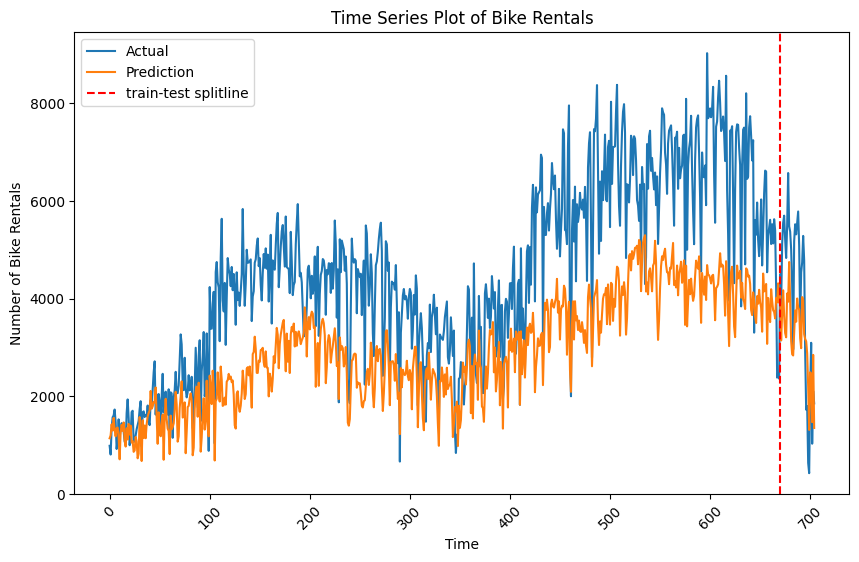

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# The NN model
# Although two-layer model is used in the task. It could be generalized to deep neural network.
class GeneralizedNeuralNetwork:
    
    def __init__(self, layer_sizes, learning_rate=0.01):
        # Initialize parameters for all layers
        self.weights = [np.random.randn(input_size, output_size) for input_size, output_size in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.zeros((1, size)) for size in layer_sizes[1:]]
        self.learning_rate = learning_rate
        
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        return np.where(x > 0, 1, 0)

    @staticmethod
    def mae_loss(y_true, y_pred):
        return np.mean(np.abs(y_true - y_pred))

    def forward_pass(self, X):
        activations = [X]
        # Compute activations for all layers
        for weight, bias in zip(self.weights, self.biases):
            z = np.dot(activations[-1], weight) + bias
            activation = self.relu(z)
            activations.append(activation)
        return activations

    def backward_pass(self, X, y_true, y_pred, activations):
        m = y_true.shape[0]
        d_loss_y_pred = np.sign(y_pred - y_true) / m
        
        grads = [d_loss_y_pred * self.relu_derivative(activations[-1])]
        
        # Loop over the layers in reverse order for backward propation
        for i in reversed(range(len(self.weights))):
            d_activation = grads[-1]
            if i > 0:
                d_activation_prev_layer = np.dot(d_activation, self.weights[i].T) * self.relu_derivative(activations[i])
                grads.append(d_activation_prev_layer)

            # Compute gradients for current layer
            d_loss_weights = np.dot(activations[i].T, d_activation)
            d_loss_biases = np.sum(d_activation, axis=0, keepdims=True)

            # Update weights and biases
            self.weights[i] -= self.learning_rate * d_loss_weights
            self.biases[i] -= self.learning_rate * d_loss_biases

        # Reverse the grads to match the order of layers
        grads.reverse()

    def train(self, X, y_true, epochs, learning_rate):
        self.learning_rate = learning_rate
        
        for epoch in range(epochs):
            # Forward pass and get all layer activations
            activations = self.forward_pass(X)
            y_pred = activations[-1]
            
            # Compute loss
            loss = self.mae_loss(y_true, y_pred)
            
            # Backward pass
            self.backward_pass(X, y_true, y_pred, activations)
            
            # Output the loss 
            if (epoch + 1) % 1000 == 0:
                print(f'Epoch {epoch + 1}, Loss: {loss}')

    def predict(self, X):
        # Use the forward pass to get the output
        activations = self.forward_pass(X)
        # The final activation is the prediction
        y_pred = activations[-1]
        return y_pred


def mae_loss(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


class OutlierDetection:
    def __init__(self, eps=1.5, min_samples=5):
        self.scaler = StandardScaler()
        self.dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.labels = None
        self.n_clusters_ = None
        self.df_outliers = None
        self.df_core = None

    def fit(self, df):
        # Standardize all features
        df_scaled = self.scaler.fit_transform(df)

        # Call DBSCAN for outlier detection
        print("\nDoing DBSCAN outliers detection.")
        self.dbscan.fit(df_scaled)

        # Labels of the clusters (-1 label is for outliers/noise/anomalies)
        self.labels = self.dbscan.labels_

        # Number of clusters in labels, excluding noise if present
        self.n_clusters_ = len(set(self.labels)) - (1 if -1 in self.labels else 0)

        # Print the number of clusters and noise points
        print(f'Estimated number of clusters: {self.n_clusters_}')
        print(f'Estimated number of noise points: {list(self.labels).count(-1)}')

        # Create a boolean mask for the outliers
        outliers_mask = self.labels == -1

        # Apply mask to get outliers and core data
        self.df_outliers = df[outliers_mask]
        self.df_core = df[~outliers_mask]

    def get_core_data(self):
        return self.df_core

    def get_outliers_data(self):
        return self.df_outliers


# main function for running the script and plot the final plot in the report
if __name__ == '__main__':
	df = pd.read_csv("./data/hour.csv")
	df.drop_duplicates()

	df.drop(['instant','dteday','cnt'], axis=1, inplace=True)

	data_X = df.drop(['casual', 'registered'], axis=1).to_numpy()
	data_Y = df[['casual', 'registered']].to_numpy()

	# Assuming 'data' is your NumPy array with features as rows and examples as columns
	total_examples = data_X.shape[0]
	split_point = int(total_examples * 0.95)  # 95% for training

	train_data_X = data_X[:split_point]
	test_data_X = data_X[split_point:]

	train_data_Y = data_Y[:split_point]
	test_data_Y = data_Y[split_point:]
	num_input_units = data_X.shape[1]

	np.random.seed(9)
	nn = GeneralizedNeuralNetwork([num_input_units,2,2])
	print("Doing NN training.")
	nn.train(train_data_X, train_data_Y, epochs=2000, learning_rate=0.01)
	test_prediction = nn.predict(test_data_X)
	test_mae = mae_loss(test_data_Y, test_prediction)

	train_prediction = nn.predict(train_data_X)
	train_mae = mae_loss(train_data_Y, train_prediction)

	print(f"The MAE error on train dataset: {train_mae:.2f}, and on test dataset: {test_mae:.2f}\n")

	# Using DBSCAN to drop outliners first. After that, train a model on it to see if it improve the model prediction
	df = pd.read_csv("./data/hour.csv")
	df.drop_duplicates()
	df.drop(['instant','dteday','cnt'], axis=1, inplace=True)

	outlier_detector = OutlierDetection(eps=1.5, min_samples=5)
	outlier_detector.fit(df)

	# Access the core and outliers data
	df_core = outlier_detector.get_core_data()
	df_outliers = outlier_detector.get_outliers_data()

	data_X = df_core.drop(['casual', 'registered'], axis=1).to_numpy()
	data_Y = df_core[['casual', 'registered']].to_numpy()

	# Assuming 'data' is your NumPy array with features as rows and examples as columns
	total_examples = data_X.shape[0]
	split_point = int(total_examples * 0.95)  # 95% for training

	train_data_X = data_X[:split_point]
	test_data_X = data_X[split_point:]

	train_data_Y = data_Y[:split_point]
	test_data_Y = data_Y[split_point:]

	np.random.seed(9)
	nn = GeneralizedNeuralNetwork([num_input_units,2,2])
	print("\nDoing NN training.")
	nn.train(train_data_X, train_data_Y, epochs=2000, learning_rate=0.01)
	test_prediction = nn.predict(test_data_X)
	test_mae = mae_loss(test_data_Y, test_prediction)

	train_prediction = nn.predict(train_data_X)
	train_mae = mae_loss(train_data_Y, train_prediction)

	print(f"The MAE error on train dataset after outlier removal: {train_mae:.2f}, and on test dataset: {test_mae:.2f}\n ")

	# Draw a very nice plot comparing bike rental prediction and actual value
	total_prediction = np.concatenate((train_prediction, test_prediction), axis = 0)

	df_prediction = pd.DataFrame(total_prediction, columns = ['casual','registered'])

	# Ground truth
	df_Y = df_core[['casual','registered']]
	df_Y['cnt'] = df_Y['casual'] + df_Y['registered'] 
	df_Y.reset_index(drop=True, inplace=True)

	# Group 24 data points together, otherwise the plot will not look nice
	df_Y['group'] = np.arange(len(df_Y)) // 24
	df_Y_grouped = df_Y.groupby('group').sum()
	df_Y_grouped = df_Y_grouped.reset_index(drop=True)

	# Model prediction
	df_prediction['cnt'] = df_prediction['casual'] + df_prediction['registered'] 
	df_prediction['cnt'] = df_prediction['cnt'].astype(int)
	df_prediction.reset_index(drop=True, inplace=True)

	df_prediction['group'] = np.arange(len(df_prediction)) // 24
	df_prediction_grouped = df_prediction.groupby('group').sum()
	df_prediction_grouped = df_prediction_grouped.reset_index(drop=True)

	# Get the number of test data points
	test_points_num = len(test_prediction) // 24
	test_points_num

	df_Y_grouped = df_Y_grouped.reset_index()
	df_prediction_grouped = df_prediction_grouped.reset_index()
	plt.figure(figsize=(10, 6))
	sns.lineplot(data=df_Y_grouped, x='index', y='cnt', label='Actual')
	sns.lineplot(data=df_prediction_grouped, x='index', y='cnt', label='Prediction')
	plt.axvline(x=len(df_prediction_grouped)-test_points_num, color='red', linestyle='--', label='train-test splitline')  
	plt.title('Time Series Plot of Bike Rentals')
	plt.xlabel('Time')
	plt.ylabel('Number of Bike Rentals')

	plt.legend()

	plt.xticks(rotation=45)

	plt.show()
